<a href="https://colab.research.google.com/github/For-Chance/CourseOfConstructionInformation/blob/master/FinalTask/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install subversion
!svn checkout https://github.com/For-Chance/CourseOfConstructionInformation/trunk/FinalTask/data

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,235 kB of archives.
After this operation, 9,916 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/unive

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
trans = pd.read_csv('./data/transactions.csv')
agency = pd.read_csv('./data/agency.csv')
agents = pd.read_csv('./data/agents.csv')

#将三张表连接起来
df = pd.merge(agency, agents)
df = pd.merge(df, trans)

#人为除去无法运算的列
df = df.drop(['Name','FirstName','LastName'], axis = 1)

#重命名列
df.rename(columns = {
    'X1 transaction date': 'X1',
    'X2 house age': 'X2',
    'X3 distance to the nearest MRT station': 'X3',
    'X4 number of convenience stores': 'X4','X5 latitude': 
    'X5','X6 longitude': 'X6',
    'Y house price of unit area':'Y'}, inplace=True)

In [4]:
#剔除异常值函数
# def outliers_removed(x):
mean, std = df.mean(), df.std()
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

df = df[(df['X1'] > lower['X1']) & (df['X1'] < upper['X1'])]
df = df[(df['X2'] > lower['X2']) & (df['X2'] < upper['X2'])]
df = df[(df['X3'] > lower['X3']) & (df['X3'] < upper['X3'])]
df = df[(df['X4'] > lower['X4']) & (df['X4'] < upper['X4'])]
df = df[(df['X5'] > lower['X5']) & (df['X5'] < upper['X5'])]
df = df[(df['X6'] > lower['X6']) & (df['X6'] < upper['X6'])]
df = df[(df['AgencyId'] > lower['AgencyId']) & (df['AgencyId'] < upper['AgencyId'])]
df = df[(df['AgentId'] > lower['AgentId']) & (df['AgentId'] < upper['AgentId'])]
df

,AgencyId,AgentId,X1,X2,X3,X4,X5,X6,Y
0,0,0,2012.667,20.4,2469.64500,4,24.96108,121.51046,23.8
1,0,0,2013.167,16.2,289.32480,5,24.98203,121.54348,46.2
2,0,0,2012.667,29.4,4510.35900,1,24.94925,121.49542,13.2
3,0,0,2012.833,31.7,1160.63200,0,24.94968,121.53009,13.7
4,0,0,2013.583,6.6,90.45606,9,24.97433,121.54310,59.0
...,...,...,...,...,...,...,...,...,...
409,2,4,2012.667,37.1,918.63570,1,24.97198,121.55063,31.9
410,2,4,2013.417,14.7,1717.19300,2,24.96447,121.51649,23.0
411,2,4,2013.000,5.2,2408.99300,0,24.95505,121.55964,22.3
412,2,4,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0


In [5]:
#确定市中心，添加新的距离属性
center_x = sum(df['X5'] * df['Y']) / df['Y'].sum()
center_y = sum(df['X6'] * df['Y']) / df['Y'].sum()
df['X7'] = ((df['X5']-center_x)**2+(df['X6']-center_y)**2)**0.5

#对两个Id列进行one-hot处理
df = pd.get_dummies(df, columns=['AgencyId','AgentId']) 

df.head()

,X1,X2,X3,X4,X5,X6,Y,X7,AgencyId_0,AgencyId_1,AgencyId_2,AgentId_0,AgentId_1,AgentId_2,AgentId_3,AgentId_4,AgentId_5
0,2012.667,20.4,2469.64500,4,24.96108,121.51046,23.8,0.028065,1,0,0,1,0,0,0,0,0
1,2013.167,16.2,289.32480,5,24.98203,121.54348,46.2,0.012641,1,0,0,1,0,0,0,0,0
2,2012.667,29.4,4510.35900,1,24.94925,121.49542,13.2,0.046732,1,0,0,1,0,0,0,0,0
3,2012.833,31.7,1160.63200,0,24.94968,121.53009,13.7,0.022723,1,0,0,1,0,0,0,0,0
4,2013.583,6.6,90.45606,9,24.97433,121.54310,59.0,0.007164,1,0,0,1,0,0,0,0,0


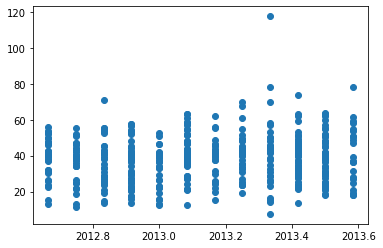

In [6]:
plt.scatter(df['X1'], df['Y']);

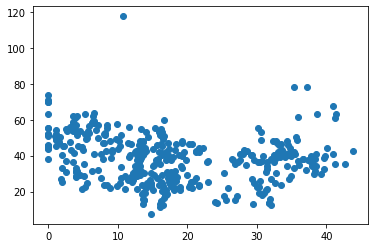

In [7]:
plt.scatter(df['X2'], df['Y']);

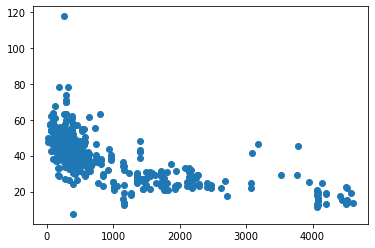

In [8]:
plt.scatter(df['X3'], df['Y']);

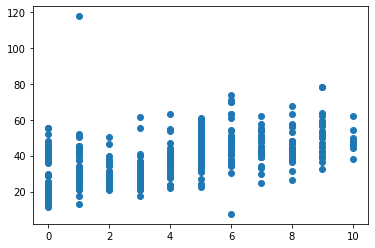

In [9]:
plt.scatter(df['X4'], df['Y']);

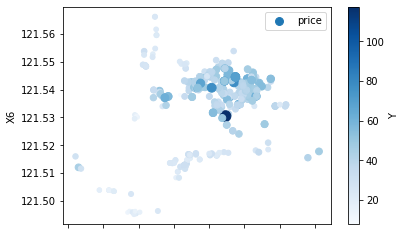

In [10]:
df.plot(kind='scatter',x='X5',y='X6',alpha=1,s=df['Y'], c='Y', label='price', colormap='Blues',colorbar=True)
plt.legend();

In [11]:
import seaborn as sns
corr = df.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Analyse")\
    .set_precision(2)\
    .set_table_styles(magnify())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


,X1,X2,X3,X4,X5,X6,Y,X7,AgencyId_0,AgencyId_1,AgencyId_2,AgentId_0,AgentId_1,AgentId_2,AgentId_3,AgentId_4,AgentId_5
X1,1.00,0.01,0.04,0.02,0.03,-0.02,0.10,0.04,0.01,-0.02,0.01,0.01,0.03,0.06,-0.05,-0.02,-0.04
X2,0.01,1.00,-0.01,0.06,0.07,-0.02,-0.20,-0.09,-0.03,-0.03,0.04,-0.03,-0.01,-0.04,0.01,0.06,-0.01
X3,0.04,-0.01,1.00,-0.62,-0.63,-0.77,-0.67,0.95,0.06,-0.04,0.01,0.06,0.04,0.03,-0.04,-0.02,-0.05
X4,0.02,0.06,-0.62,1.00,0.46,0.44,0.56,-0.55,-0.08,-0.01,0.06,-0.08,0.04,-0.03,0.03,0.04,-0.03
X5,0.03,0.07,-0.63,0.46,1.00,0.41,0.55,-0.64,-0.04,0.05,-0.03,-0.04,-0.04,0.00,0.04,0.00,0.03
X6,-0.02,-0.02,-0.77,0.44,0.41,1.00,0.50,-0.69,-0.07,0.05,-0.01,-0.07,-0.04,0.00,0.02,0.03,0.04
Y,0.10,-0.20,-0.67,0.56,0.55,0.50,1.00,-0.63,-0.06,0.02,0.02,-0.06,0.01,-0.05,0.00,0.01,0.09
X7,0.04,-0.09,0.95,-0.55,-0.64,-0.69,-0.63,1.00,0.07,-0.04,0.00,0.07,0.04,0.05,-0.05,-0.04,-0.06
AgencyId_0,0.01,-0.03,0.06,-0.08,-0.04,-0.07,-0.06,0.07,1.00,-0.35,-0.25,1.00,-0.15,-0.17,-0.17,-0.15,-0.11
AgencyId_1,-0.02,-0.03,-0.04,-0.01,0.05,0.05,0.02,-0.04,-0.35,1.00,-0.82,-0.35,-0.51,0.47,0.50,-0.51,0.32


In [12]:
from sklearn.model_selection import train_test_split

X = df[['X3','X4','X7']].copy()
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1)

print('X train shape:', X_train.shape)
print('X test shape:', X_test.shape)
print('y train shape:', y_train.shape)
print('y test shape:', y_test.shape)
X.head()

X train shape: (306, 3)
X test shape: (102, 3)
y train shape: (306,)
y test shape: (102,)


,X3,X4,X7
0,2469.64500,4,0.028065
1,289.32480,5,0.012641
2,4510.35900,1,0.046732
3,1160.63200,0,0.022723
4,90.45606,9,0.007164


In [13]:
y.head()

0    23.8
1    46.2
2    13.2
3    13.7
4    59.0
Name: Y, dtype: float64

In [14]:
#每列归一化处理
X['X3'] = (X['X3']-X['X3'].min())/(X['X3'].max()-X['X3'].min())
X['X4'] = (X['X4']-X['X4'].min())/(X['X4'].max()-X['X4'].min())
X['X7'] = (X['X7']-X['X7'].min())/(X['X7'].max()-X['X7'].min())
X.head()

,X3,X4,X7
0,0.533843,0.4,0.581111
1,0.058036,0.5,0.250637
2,0.979183,0.1,0.981051
3,0.248179,0.0,0.466641
4,0.014637,0.9,0.133301


In [15]:
def print_mae_train(model, X, y):
    pred = model.predict(X)
    error = np.mean(np.abs(y-pred))
    print("MAE error for train set: {:.1f}".format(error))
def print_mae_test(model, X, y):
    pred = model.predict(X)
    error = np.mean(np.abs(y-pred))
    print("MAE error for test set: {:.1f}".format(error))

def print_mape_train(model, X, y):
    pred = model.predict(X)
    error = np.mean(100 * np.abs((y-pred) / y))
    print("MAPE error for train set: {:.1f}%".format(error))
def print_mape_test(model, X, y):
    pred = model.predict(X)
    error = np.mean(100 * np.abs((y-pred) / y))
    print("MAPE error for test set: {:.1f}%".format(error))

In [16]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

print_mae_train(model, X_train, y_train)
print_mae_test(model, X_test, y_test)
print_mape_train(model, X_train, y_train)
print_mape_test(model, X_test, y_test)
print("Train set accuracy:", model.score(X_train, y_train))
print("Test set accuracy:", model.score(X_test, y_test))


MAE error for train set: 7.2
MAE error for test set: 6.4
MAPE error for train set: 20.4%
MAPE error for test set: 21.5%
Train set accuracy: 0.5043946735848913
Test set accuracy: 0.4111634296762765


In [17]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(min_samples_leaf=13)
model.fit(X_train,y_train)

print_mae_train(model, X_train, y_train)
print_mae_test(model, X_test, y_test)
print_mape_train(model, X_train, y_train)
print_mape_test(model, X_test, y_test)
print("Train set accuracy:", model.score(X_train, y_train))
print("Test set accuracy:", model.score(X_test, y_test))

MAE error for train set: 5.5
MAE error for test set: 5.2
MAPE error for train set: 15.4%
MAPE error for test set: 17.7%
Train set accuracy: 0.6903128053671397
Test set accuracy: 0.5380317336715281
